## Neutron Scattered Spectra Tool (NeSST) ##

This notebook will offer a quick guide to some of the functionality of NeSST

Standard packages:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.formatter.limits'] = (-2,2)
import NeSST as nst

## Table of Contents:
* [Overview](#first-bullet)
* [Scattering from Arbitrary Areal Density Distribution](#second-bullet)
* [Additional Materials](#third-bullet)
* [Scattering Ion Kinematics](#fourth-bullet)
* [DT Fitting Function](#fifth-bullet)
* [Time of Flight synthetic diagnostic](#sixth-bullet)

# Overview <a class="anchor" id="first-bullet"></a>

NeSST is equipped to handle the primary and scattered components found in DT plasmas

### Primary Neutron Spectra ###

DT and DD primary neutron spectra can be constructed for Ballabio's spectral moments and appropriate spectrum form. Reactivities are taken from Bosch & Hale (or in the case of TT from direct integration of ENDF data).

In [2]:
# N.B. functions that take D/T fractions have default values for these arguments of 0.5
frac_D = 0.5
frac_T = 0.5

Tion = 5.0e3 # eV
Y_DT = 1.0   # DT neutron yield, all reactions scaled by this value

DTmean,DTstddev,DTvar = nst.DTprimspecmoments(Tion)
DDmean,DDstddev,DDvar = nst.DDprimspecmoments(Tion)

Y_DD = nst.yield_from_dt_yield_ratio('dd',Y_DT,Tion,frac_D=frac_D,frac_T=frac_T)
Y_TT = nst.yield_from_dt_yield_ratio('tt',Y_DT,Tion,frac_D=frac_D,frac_T=frac_T)

# DD and TT grid
E_pspec = np.linspace(1.0e6,10.0e6,300)
# DT grid
E_DTspec = np.linspace(12.5e6,15.5e6,200)
E_pspec = np.append(E_pspec,E_DTspec)

dNdE_DT = Y_DT*nst.QBrysk(E_pspec,DTmean,DTvar) # Brysk shape i.e. Gaussian
dNdE_DD = Y_DD*nst.QBrysk(E_pspec,DDmean,DDvar) # Brysk shape i.e. Gaussian
dNdE_TT = Y_TT*nst.dNdE_TT(E_pspec,Tion)

Text(0,0.5,'dN/dE (1/eV)')

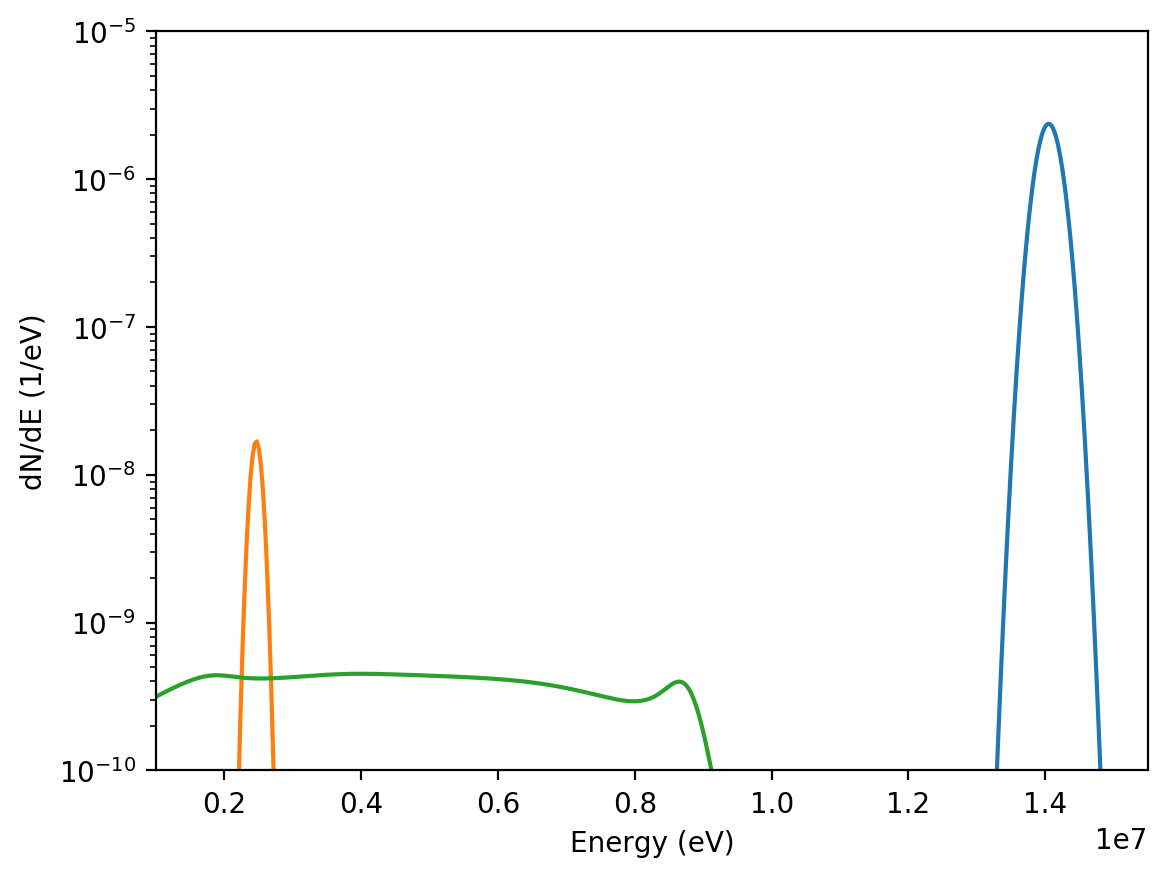

In [3]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)

plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(1e-10,1e-5)
plt.xlabel("Energy (eV)")
plt.ylabel("dN/dE (1/eV)")

There are multiple approximations for the shape of the 2-body primary peaks (DT and DD). Here we show Brysk and Ballabio, both included in NeSST:

N.B. will add comparison to DRESS here

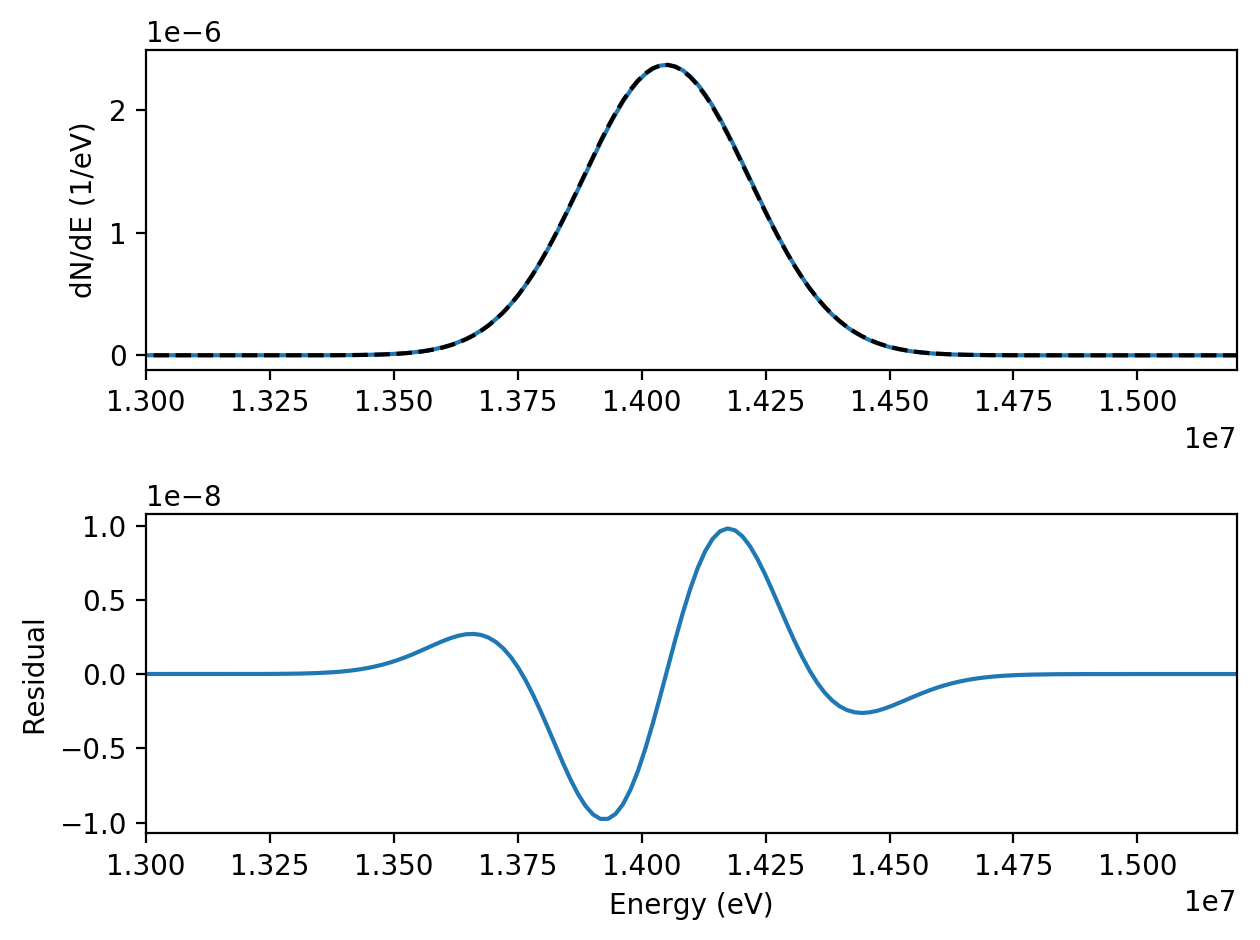

In [4]:
dNdE_DT_Ballabio = Y_DT*nst.QBallabio(E_pspec,DTmean,DTvar)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212,sharex=ax1)

ax1.plot(E_pspec,dNdE_DT)
ax1.plot(E_pspec,dNdE_DT_Ballabio,'k--')

ax2.plot(E_pspec,dNdE_DT-dNdE_DT_Ballabio)
RMSE = np.sqrt(np.average((dNdE_DT-dNdE_DT_Ballabio)**2,weights=dNdE_DT))
assert RMSE < 1e-8

ax1.set_xlim(1.3e7,1.52e7)
ax2.set_xlabel("Energy (eV)")
ax1.set_ylabel("dN/dE (1/eV)")
ax2.set_ylabel("Residual")

fig.tight_layout()

### Cross sections ###

For the elastic nT and nD scattering we use ENDF total and differential cross sections. These are defined using a Legendre polynomial expansions.

For the D(n,2n) process, we use the CENDL double differential cross section - the $d\sigma/dE$ of this data has been compared against the Deltuva calculation and shows good agreement

For the T(n,2n) process, we use the ENDF cross section and LAW=6 phase space law - this process carries the most uncertainity in terms of spectral shape and magnitude

### Scattered spectra for symmetric areal density ###

Scattered spectra for symmetric areal density are calculated from the single differential cross sections:

$$\frac{dN}{dE}_{\mathrm{scatter}} = A_{1S}\int dE' \frac{d\sigma}{dE}\frac{dN}{dE}_{\mathrm{primary}}, $$

where $A_{1S}$ is the single scatter amplitude which is directly proportional to the neutron-averaged areal density

In [5]:
I_prim = dNdE_DT+dNdE_DD+dNdE_TT

# Scattered spectra and primary spectra can be on separate grids
E_sspec = np.linspace(1.0e6,16.0e6,400)

# Neutron-averaged areal density in kg/m2
rhoL = 1.50
# Need convert this into single scattering amplitude A_1S
A_1s = nst.rhoR_2_A1s(rhoL)

In [6]:
# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_pspec)

In [7]:
nst.sm.mat_D.calc_dNdEs(I_prim,lambda x : np.ones_like(x))

In [8]:
# Calculate the various scattering components for uniform areal density
dNdE_scatter,components = nst.DT_sym_scatter_spec(I_prim,frac_D=frac_D,frac_T=frac_T)

By factoring out the areal density and yield scaling, this allows rapid evaluation of spectral shapes for different yields and areal densities

In [9]:
# Appropriate scaling by areal density
dNdE_scatter *= A_1s
nD,nT,Dn2n,Tn2n = components
nD *= A_1s
nT *= A_1s
Dn2n *= A_1s
Tn2n *= A_1s

Text(0,0.5,'dN/dE (1/eV)')

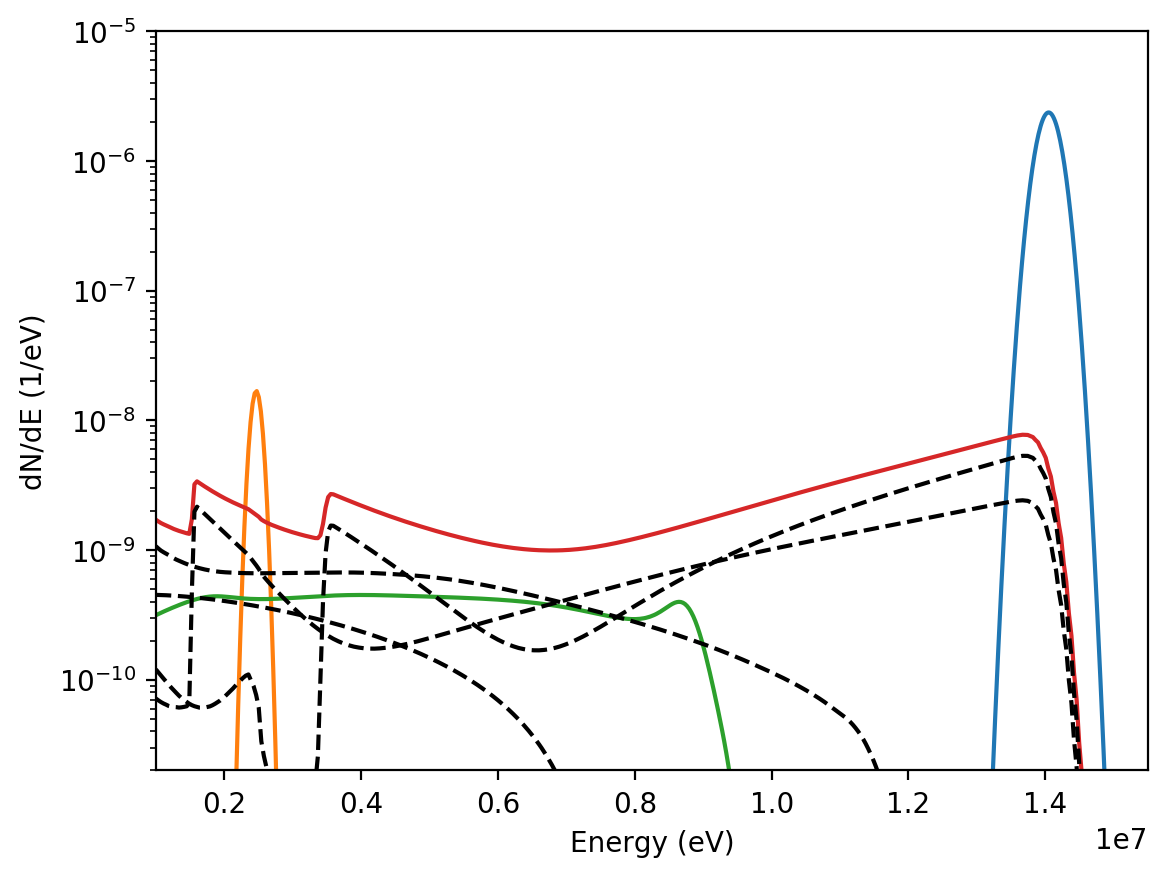

In [10]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)
plt.semilogy(E_sspec,dNdE_scatter)
#Components
plt.semilogy(E_sspec,nD,'k--')
plt.semilogy(E_sspec,nT,'k--')
plt.semilogy(E_sspec,Dn2n,'k--')
plt.semilogy(E_sspec,Tn2n,'k--')

plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(2e-11,1e-5)
plt.xlabel("Energy (eV)")
plt.ylabel("dN/dE (1/eV)")

### Comparison to neutron transport solution ###

Minotaur is a 1D spherical discrete ordinates neutron transport code which computes neutron spectra based on input hydrodynamic profiles for ICF implosions. Transport effects, temperature and density profiles, and multiple scattering absent from NeSST can be quantified by Minotaur. For details on the code see "Synthetic nuclear diagnostics for inferring plasma properties of inertial confinement fusion implosions" https://aip.scitation.org/doi/full/10.1063/1.5027462

Here we compare NeSST's scattered spectrum to one calculated by Minotaur for an isobaric hotspot + cold shell model. This comparison will be performed at a rhoR of 200 mg/cm$^2$ - although the neutron-averaged areal density will not be exactly equal due to profile effects.

In [11]:
# Prepare NeSST result with Minotaur results
burn_avg_tion = 4.06487e3 # eV
Mino_Y_DT     = 9593467571589.95 # DT neutron yield

Mino_DTmean,_,Mino_DTvar = nst.DTprimspecmoments(burn_avg_tion)
Mino_DDmean,_,Mino_DDvar = nst.DDprimspecmoments(burn_avg_tion)

Mino_Y_DD = nst.yield_from_dt_yield_ratio('dd',Mino_Y_DT,burn_avg_tion)
Mino_Y_TT = nst.yield_from_dt_yield_ratio('tt',Mino_Y_DT,burn_avg_tion)

Mino_dNdE_DT = Mino_Y_DT*nst.QBrysk(E_sspec,Mino_DTmean,Mino_DTvar) # Brysk shape i.e. Gaussian
Mino_dNdE_DD = Mino_Y_DD*nst.QBrysk(E_sspec,Mino_DDmean,Mino_DDvar) # Brysk shape i.e. Gaussian
Mino_dNdE_TT = Mino_Y_TT*nst.dNdE_TT(E_sspec,burn_avg_tion)

Mino_I_prim = Mino_dNdE_DT+Mino_dNdE_DD+Mino_dNdE_TT

# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_sspec)

Mino_dNdE_scatter,Mino_components = nst.DT_sym_scatter_spec(Mino_I_prim)

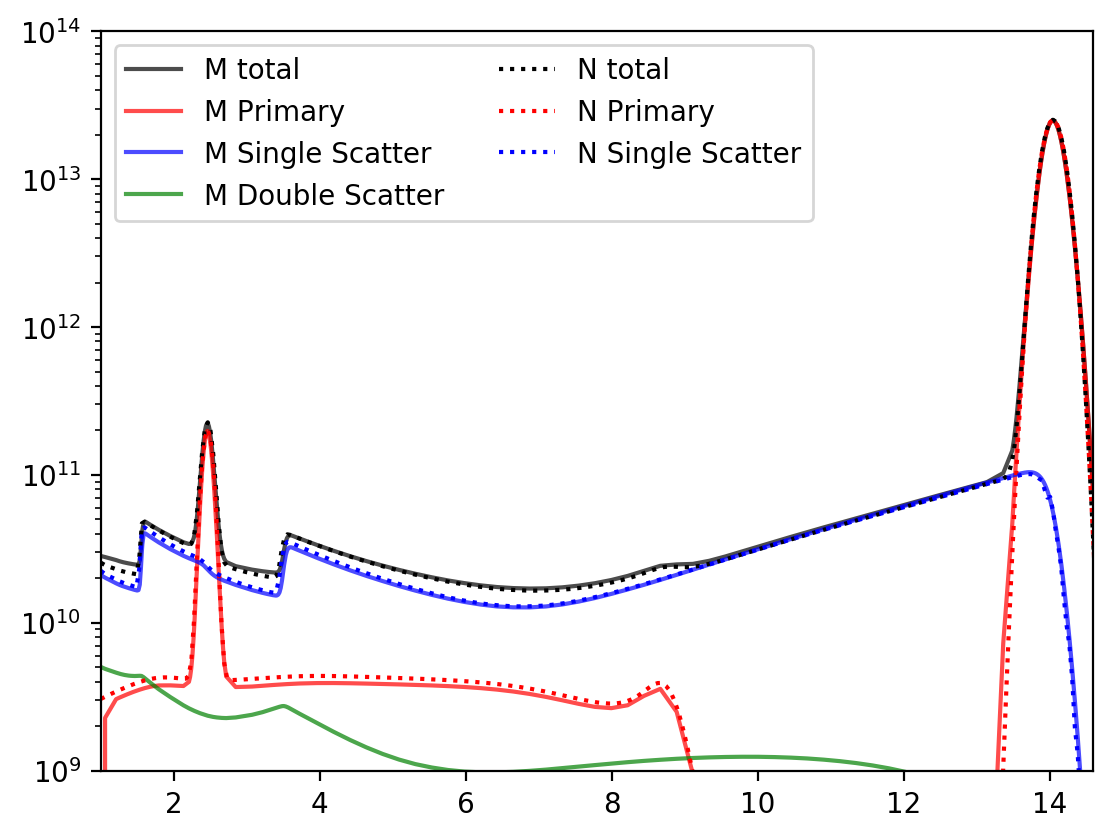

In [12]:
Minotaur_data = np.loadtxt("energy_spec_200mgcm2_isobaric_NeSST.dat")

plt.figure(dpi=200)

plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,3],'k',alpha=0.7,label='M total')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,5],'r',alpha=0.7,label='M Primary')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,6],'b',alpha=0.7,label='M Single Scatter')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,7],'g',alpha=0.7,label='M Double Scatter')

Mino_A_1s = nst.rhoR_2_A1s(2.03)

plt.semilogy(E_sspec/1e6,Mino_I_prim*1e6+Mino_A_1s*Mino_dNdE_scatter*1e6,'k:',label='N total')
plt.semilogy(E_sspec/1e6,Mino_I_prim*1e6,'r:',label='N Primary')
plt.semilogy(E_sspec/1e6,Mino_A_1s*Mino_dNdE_scatter*1e6,'b:',label='N Single Scatter')

plt.legend(ncol=2)
plt.xlim(1.0,Minotaur_data[0,0])
plt.ylim(1e9,1e14)
# Compute RMSE
RMSE = np.sqrt(np.mean((Minotaur_data[:,3]-np.interp(Minotaur_data[:,0],E_sspec/1e6,Mino_I_prim*1e6+Mino_A_1s*Mino_dNdE_scatter*1e6))**2))/Mino_Y_DT
assert RMSE < 0.06

Minotaur results are labelled 'M' and NeSST results are labelled 'N'

The comparison shows the strength and speed of NeSST in the single scatter regime, where the double scattering contribution can be considered a small background.

Also note the differences in the backscatter edge positions - this is due to the relativistic corrections present in NeSST but not Minotaur

# Scattered spectra for arbitrary areal density asymmetry <a class="anchor" id="second-bullet"></a>

Scattered spectra for asymmetric areal density distributions are calculated from the double differential cross sections:

$$\frac{dN}{dE}_{\mathrm{scatter}} = A_{1S}\int d\mu \frac{\langle \rho L \rangle (\mu)}{\langle \rho L \rangle_0} \int dE' \frac{d^2\sigma}{dEd\mu}\frac{dN}{dE}_{\mathrm{primary}}, $$

where $\langle \rho L \rangle (\mu)$ is the project areal density asymmetry along the line of sight and $\langle \rho L \rangle_0$ is the mode 0 i.e. 4 $\pi$ average areal density.

For details on this treatment see "The effect of areal density asymmetries on scattered neutron spectra in ICF implosions" https://aip.scitation.org/doi/full/10.1063/5.0038752

In [13]:
# Swap back to separate primary and scattered spectra grids
# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_pspec)

Text(0,0.5,'Normalised Areal Density')

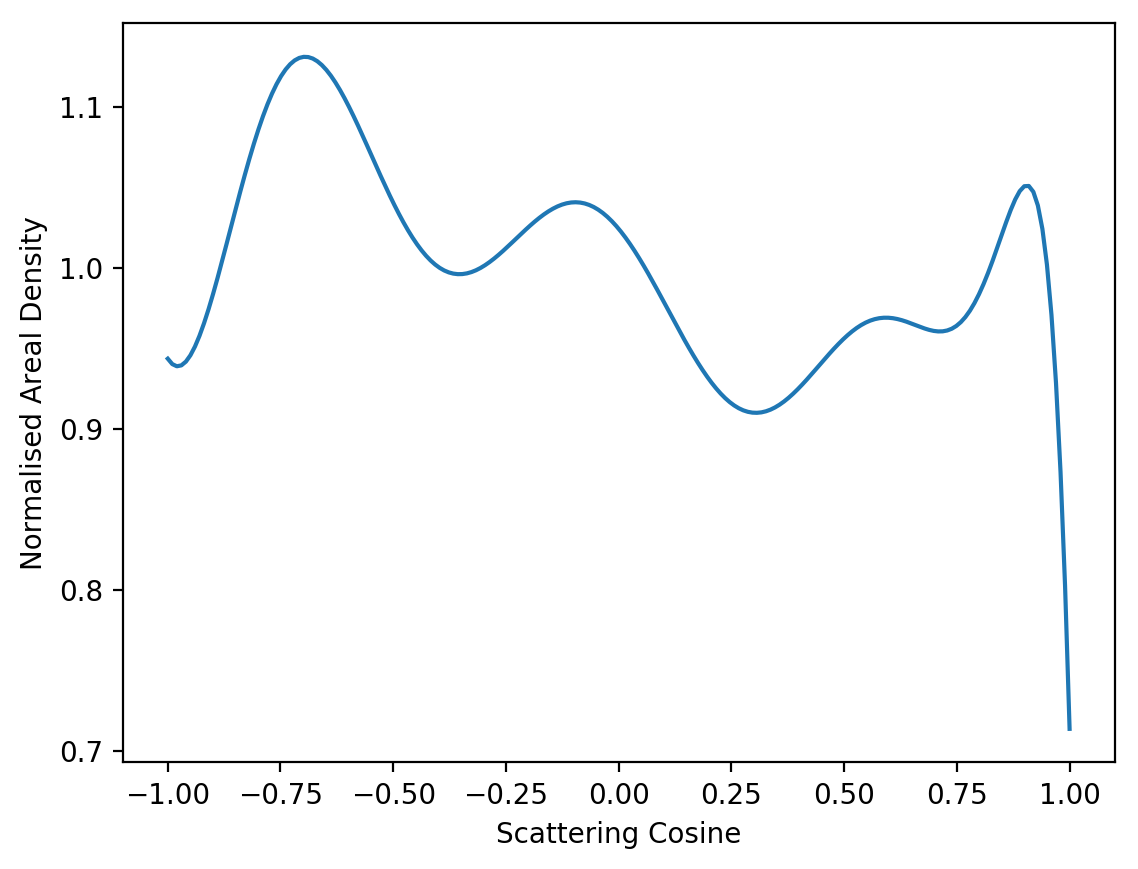

In [14]:
def rhoL_func(cos,p):
    return np.polynomial.legendre.legval(cos,p)

coeff = 0.2*(np.random.rand(12)-0.5)
coeff[0] = 1.0

fig = plt.figure(dpi=200)

cos = np.linspace(-1,1,200)

plt.plot(cos,rhoL_func(cos,coeff))
plt.xlabel("Scattering Cosine")
plt.ylabel("Normalised Areal Density")

In [15]:
# Use the defined areal density asymmetry function to find scattered spectrum
asym_dNdE_scatter, components = nst.DT_asym_scatter_spec(I_prim,lambda x: rhoL_func(x,coeff),frac_D=frac_D,frac_T=frac_T)

In [16]:
# Appropriate scaling by areal density
asym_dNdE_scatter *= A_1s

Text(0,0.5,'dN/dE (1/eV)')

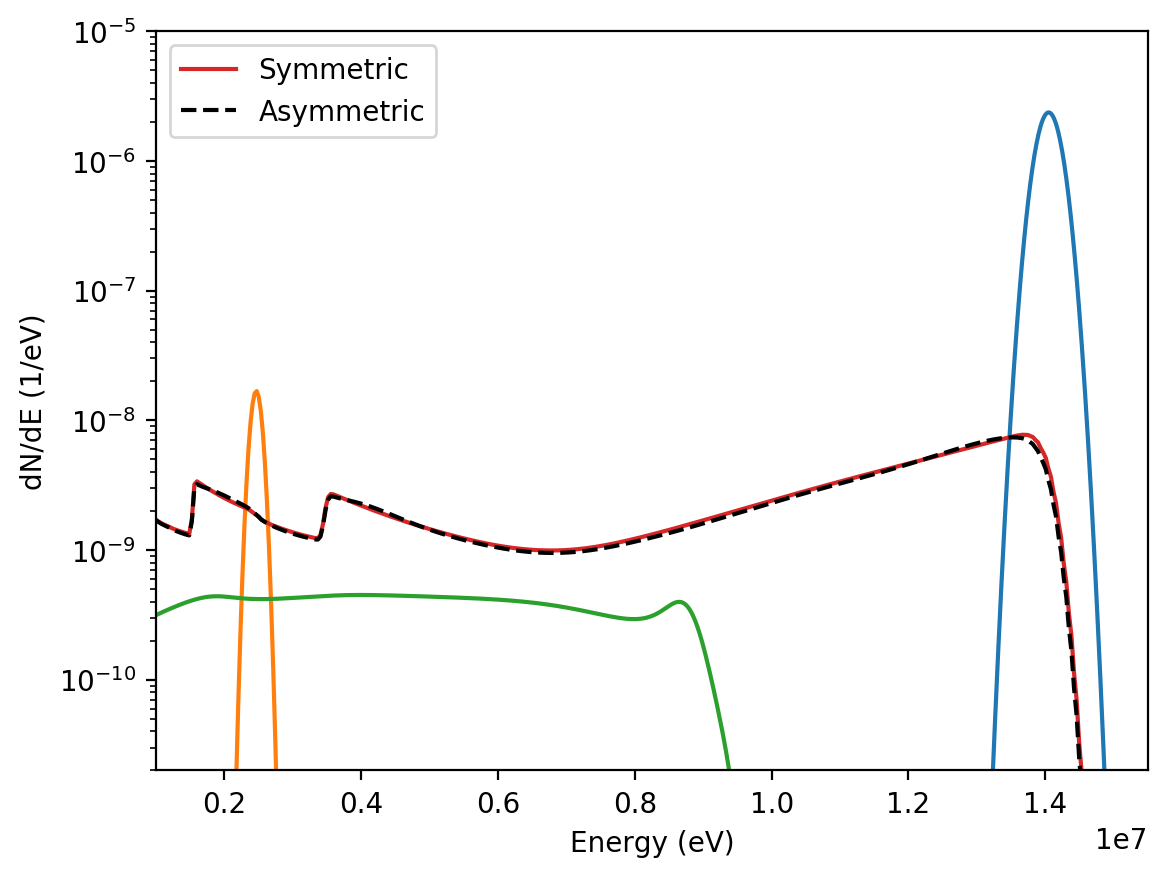

In [17]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)
plt.semilogy(E_sspec,dNdE_scatter,label='Symmetric')
plt.semilogy(E_sspec,asym_dNdE_scatter,'k--',label='Asymmetric')

plt.legend()
plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(2e-11,1e-5)
plt.xlabel("Energy (eV)")
plt.ylabel("dN/dE (1/eV)")

# Additional Materials <a class="anchor" id="third-bullet"></a>

NeSST can include the scattering from non-fuel components through the material_data object in the NeSST.spectral_model library. The currently available materials are stored in NeSST.available_materials.

In [18]:
print(nst.available_materials)

['H', 'D', 'T', '12C', '9Be']


We will see how to use these additional material data objects using 9Be as an example

We need to supply the energy grids for the primary and scattered spectra, and the areal density as a function of scattering cosine. NeSST will then calculate the unscaled dNdEs.

In [19]:
EBe_sspec,EBe_pspec = np.linspace(1.0e6,3.0e6,200),np.linspace(2.0e6,3.0e6,200)

dNdE_DD_Be = nst.QBrysk(EBe_pspec,DDmean,DDvar) # Brysk shape i.e. Gaussian

mat_9Be = nst.init_mat_scatter(EBe_sspec,EBe_pspec,'9Be')
scatter_9Be_total = nst.mat_scatter_spec(mat_9Be,dNdE_DD_Be,lambda x : np.ones_like(x))

Each material has an in-built way to calculate the conversion between material areal density and scatter fraction (A_1S).

Text(0,0.5,'dN/dE (1/eV)')

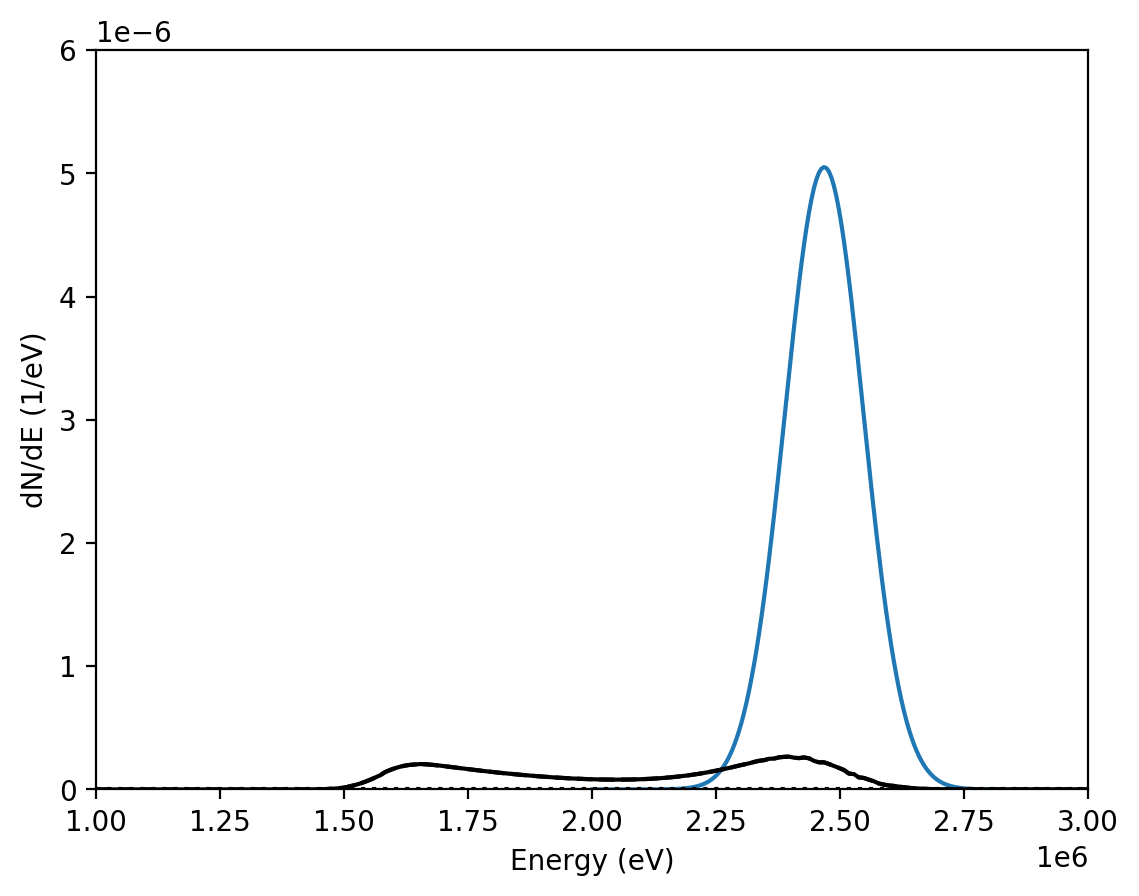

In [20]:
rhoR = 10.0 # kg/m^2
A_1S = mat_9Be.rhoR_2_A1s(rhoR)

plt.figure(dpi=200)

plt.plot(EBe_pspec,dNdE_DD_Be)
dNdE_scatter = A_1S*scatter_9Be_total
plt.plot(EBe_sspec,dNdE_scatter,'k')
# Components
plt.plot(EBe_sspec,A_1S*mat_9Be.elastic_dNdE,'k--')
plt.plot(EBe_sspec,A_1S*mat_9Be.n2n_dNdE,'k:')

plt.xlim(EBe_sspec[0],EBe_sspec[-1])
plt.ylim(0.0,6e-6)
plt.xlabel("Energy (eV)")
plt.ylabel("dN/dE (1/eV)")

# Scattering Ion Kinematics <a class="anchor" id="fourth-bullet"></a>

### Effect of scattering ion kinematics on backscatter edge shape ###

The theory behind this effect is outlined in "Neutron backscatter edge: A measure of the hydrodynamic properties of the dense DT fuel at stagnation in ICF experiments" https://aip.scitation.org/doi/full/10.1063/1.5128830

First, we must construct a ion velocity dependent scattering kernel. For this example, we concentrate on the scattering of DT neutrons from T. To speed up the calculation we will not compute the nD ion kinematic scattering matrices (nD=False in init_DT_ionkin_scatter and calc_DT_ionkin_primspec_rhoL_integral):

In [21]:
# Energy grid for nT edge, zoom in on region of interest
E_nT = np.linspace(3.0e6,4.5e6,200)

# Ion velocity grid
varr = np.linspace(-800e3,800e3,100)
nst.init_DT_scatter(E_nT,E_DTspec)
nst.init_DT_ionkin_scatter(varr,nT=True,nD=False)

We can then include the primary spectrum shape effect on the scattered signals, at this point one can also include an asymmetric areal density distribution

In [22]:
# DT spectrum on DT spec grid
I_DT = nst.QBrysk(E_DTspec,DTmean,DTvar)
nst.calc_DT_ionkin_primspec_rhoL_integral(I_DT,nT=True,nD=False)

We can now evaluate what the scattered spectrum looks like for a particular distribution of scattering ion velocities. In the following we consider a Gaussian distribution with mean and standard deviation given by vbar and dv respectively

In [23]:
# Mean and std. dev. of ion velocity distribution
vbar = 80.0e3 # m/s
dv   = 250.0e3 # m/s

dNdE,components                   = nst.DT_scatter_spec_w_ionkin(I_DT,vbar,dv,rhoL_func= lambda x : np.ones_like(x),frac_D=frac_D,frac_T=frac_T)
dNdE_noionvel,components_noionvel = nst.DT_sym_scatter_spec(I_DT,frac_D=frac_D,frac_T=frac_T)

# Neutron-averaged areal density in kg/m2
rhoL = 1.50
# Need convert this into single scattering amplitude A_1S
A_1s = nst.rhoR_2_A1s(rhoL)

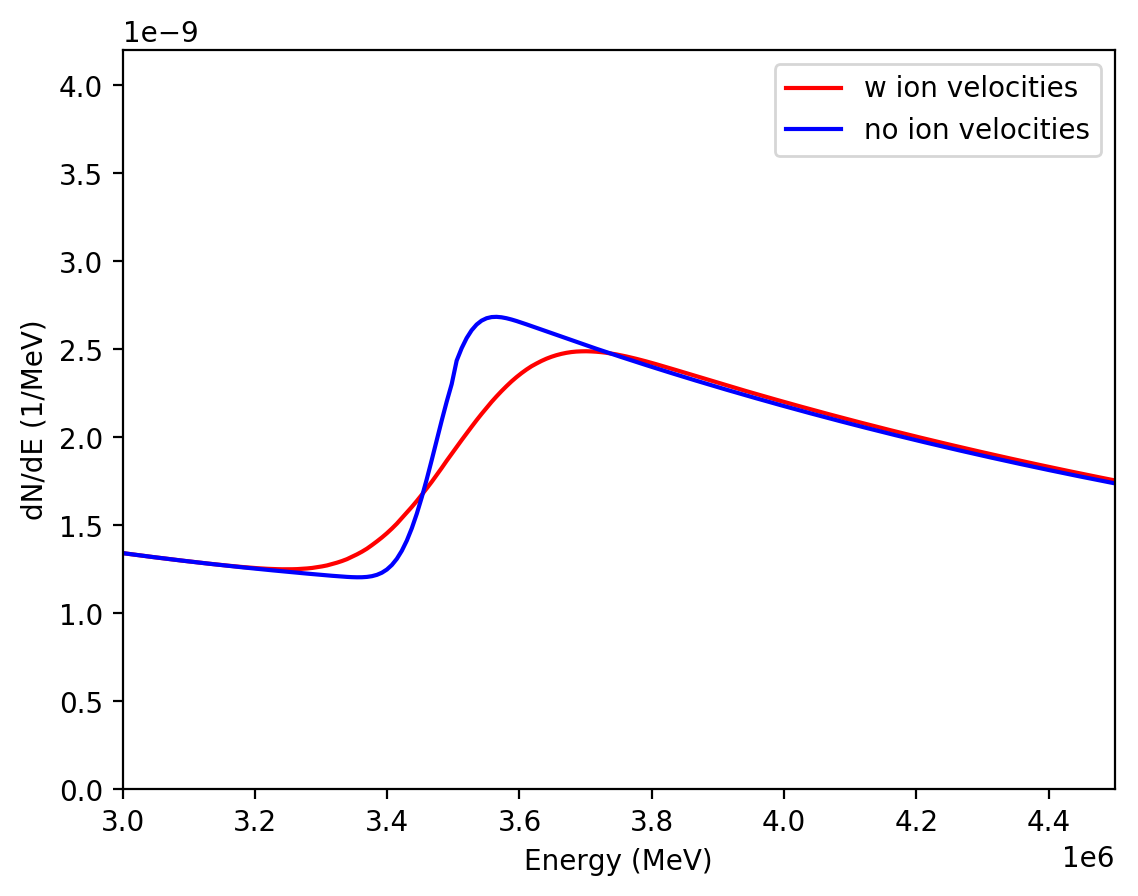

In [24]:
plt.figure(dpi=200)

plt.plot(E_nT,A_1s*dNdE,'r',label='w ion velocities')
plt.plot(E_nT,A_1s*dNdE_noionvel,'b',label='no ion velocities')

plt.xlim(E_nT[0],E_nT[-1])
plt.ylim(0,4.2e-9)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")
plt.legend()

# DT fitting function <a class="anchor" id="fifth-bullet"></a>

So far we have used NeSST to compute the primary and scattered spectra in one-off instances. More often, we want to fit our model to experimental data - this requires that we can quickly evaluate the model at various different input parameters. Towards this end, NeSST contains a fitting module for DT spectra where a splined model is constructed allowing for quick evaluation and interpolation between energy grid points.

First we must build the scattering matrices on specified energy and ion velocity grids, this can be time consuming depending on the number grid points chosen. However, this step need only be performed once before a large number of datasets can be fit.

In [25]:
# Consider only scattering of DT fusion neutrons
E_DTspec = np.linspace(13.0e6,15.0e6,100)
# Scattered spectra and primary spectra can be on separate grids
E_sspec = np.linspace(1.0e6,2.75e6,50,endpoint=False)
E_sspec = np.append(E_sspec,np.linspace(2.75e6,8.0e6,450,endpoint=False))
E_sspec = np.append(E_sspec,np.linspace(8.0e6,15.0e6,50))
# Ion velocity grid
varr = np.linspace(-1200e3,1200e3,150)

DT_spec_fit = nst.fitting.DT_fit_function(E_DTspec,E_sspec,varr)

### Initialising data on energy grids... ###
### Initialising scattering matrices on ion velocity grid... ###
### Init Done. ###


To build the model we need to specify the primary spectral (through a single temperature):

In [26]:
Tion = 5.0e3 # eV

DT_spec_fit.set_primary_Tion(Tion)

and also specify the form of the areal density distribution. Two models are in-built to NeSST - symmetric and mode 1. We will look at the mode 1 model here:

In [27]:
P1_arr = np.linspace(-0.6,0.6,11)

DT_spec_fit.init_modeone_model(P1_arr)

Once a model has been initialised it can be called by the .model(...) method. For example:

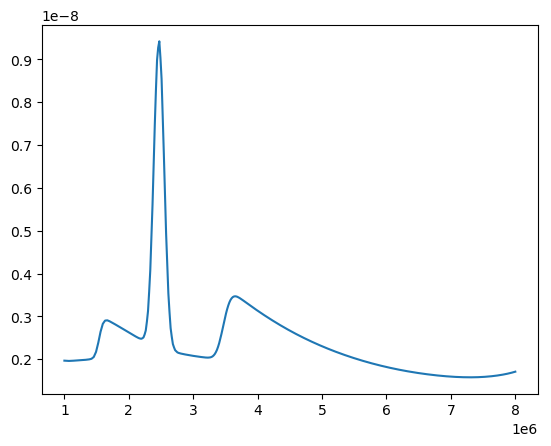

In [28]:
E = np.linspace(1.0e6,8.0e6,400)
rhoL = 1.50
P1   = 0.2
vbar = 0.0e3
dv   = 200e3
fT   = 0.7
fD   = 0.3
Yn   = 1.0

plt.plot(E,DT_spec_fit.model(E,rhoL,P1,vbar,dv,fT,fD,Yn))

To show an example of its usage, we will create some synthetic data from the model, add noise, and then use the model to fit the synthetic data

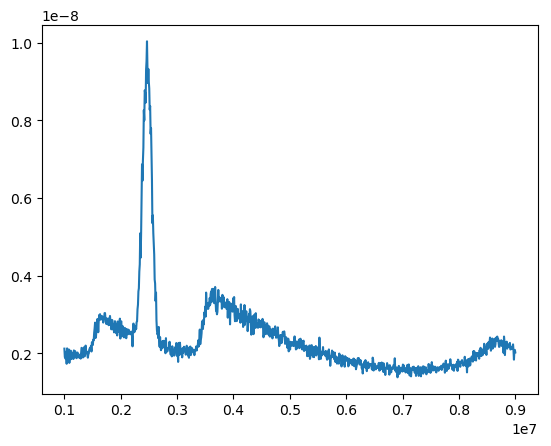

In [29]:
E_data = np.linspace(1.0e6,9.0e6,1000)
data   = DT_spec_fit.model(E_data,rhoL,P1,vbar,dv,fT,fD,Yn)
np.random.seed(1)
data  *= np.random.normal(loc=1.0,scale=0.05,size=E_data.shape[0])

plt.plot(E_data,data)

Here we define a few useful functions to perform $\chi^2$ minimisation fitting using our model function:

In [30]:
from scipy.optimize import minimize

def fit_maximum_a_posterior(E,spec,modelfunc,fit_range_func,initial,params,relative_err,bounds):
    idx_cut = fit_range_func(E)
    
    specerr = relative_err*spec
    soln = minimize(neg_log_likelihood, initial, args=(modelfunc, params, idx_cut, E, spec, specerr), bounds = bounds,
                    method='TNC',tol=1e-9)

    loss_soln = neg_log_likelihood(soln.x,modelfunc,params,idx_cut,E,spec,specerr)/len(idx_cut)
    loss_init = neg_log_likelihood(initial,modelfunc,params,idx_cut,E,spec,specerr)/len(idx_cut)
    return soln,loss_soln,loss_init

def neg_log_likelihood(theta, modelfunc, params, idx_cut, x, y, yerr):
    p = [*theta,*params]
    model = modelfunc(x,*p)
    # Chi^2
    return 0.5 * np.sum(((y[idx_cut] - model[idx_cut])/yerr[idx_cut])**2)

def fit_range(x):
    return (((x < 8.0e6) & (x > 3.0e6)))

Finally, here is the resulting best fit of model to data:

True: 1.5, Fit: 1.4885007050938097
True: 0.2, Fit: 0.21683903845950178
True: 0.0, Fit: -0.43963844233114924
True: 200000.0, Fit: 152981.73822655503


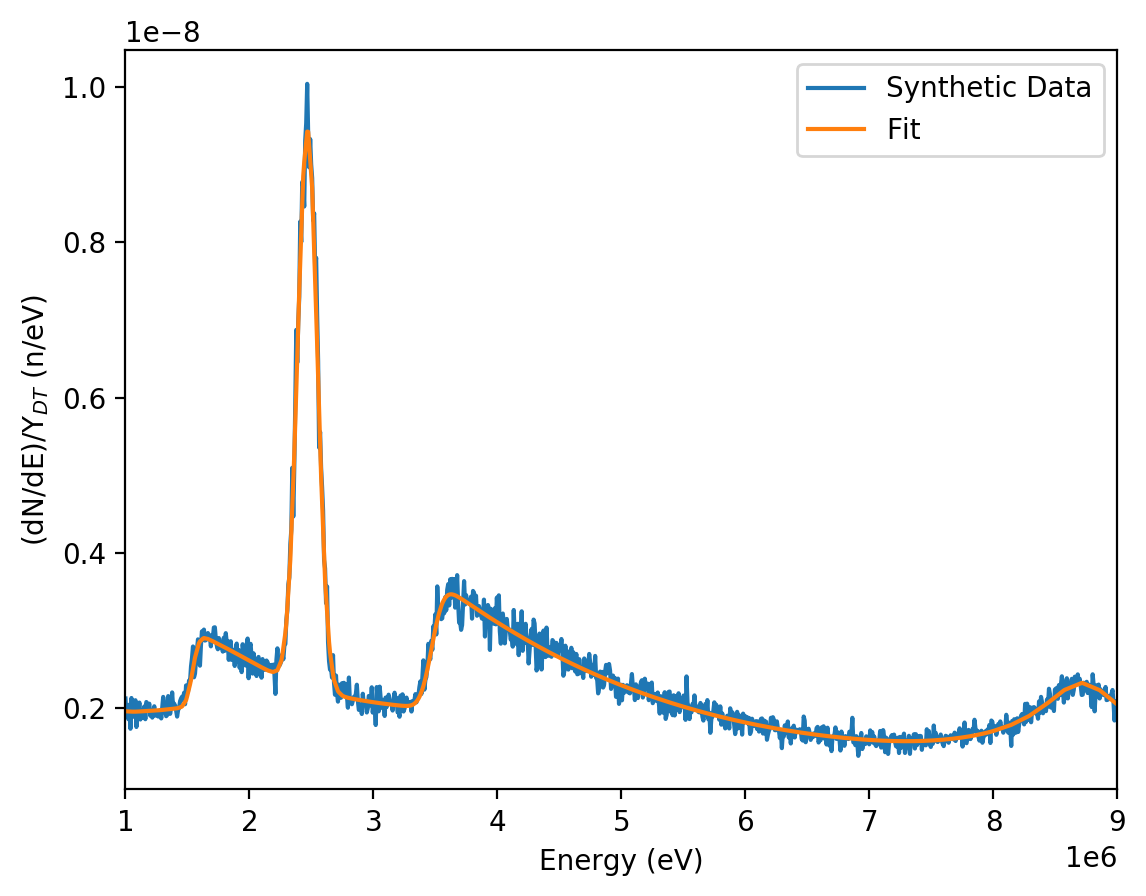

In [31]:
plt.figure(dpi=200)

# We don't know the areal density, mode 1 amplitude, and edge parameters
initial_guess = [1.500,0.0,0.0e3,150e3]
# Absolute fit tolerances to test
tolerances = [0.1,0.05,10e3,50e3]
# We know the fuel fractions and DT yield
params = [0.7,0.3,1.0]
bounds = ((0.0,np.inf),(-0.5,0.5),(-np.inf,np.inf),(50e3,np.inf))

soln,loss_soln,loss_init = fit_maximum_a_posterior(E_data,data,DT_spec_fit.model,fit_range
                                                   ,initial_guess,params,0.05,bounds)

true_values = [rhoL,P1,vbar,dv]
for i in range(len(true_values)):
    print("True: {}, Fit: {}".format(true_values[i],soln.x[i]))
    assert np.isclose(true_values[i],soln.x[i],atol=tolerances[i])

plt.plot(E_data,data,label='Synthetic Data')
plt.plot(E_data,DT_spec_fit.model(E_data,*soln.x,*params),label='Fit')

plt.axvline(3.0,c='k')
plt.axvline(8.0,c='k')
plt.xlim(1e6,9e6)
plt.xlabel("Energy (eV)")
plt.ylabel(r"(dN/dE)/Y$_{DT}$ (n/eV)")
plt.legend()

# Time of Flight synthetic diagnostic <a class="anchor" id="sixth-bullet"></a>

A common method for the measurement of neutron spectra are time-of-flight spectrometers. NeSST has a in-built class which handles the conversion of energy spectra to time of flight signals. This follows the literature methodology:

$$
I(t_d) \propto \left(S(E_n)\frac{dN}{dE}\frac{dE}{dt}\right)\times R(E_n,t_d-t_a(E_n))
$$

Where $E_n$ is the neutron energy, $t_d$ is the detected time, $t_a$ is the arrival time, $S$ is the sensitivity function and $R$ is the instrument response function. For further details see [Hatarik](https://pubs.aip.org/aip/jap/article/118/18/184502/140977/Analysis-of-the-neutron-time-of-flight-spectra) and [Mohamed](https://pubs.aip.org/aip/jap/article/128/21/214501/1078858) papers.

Below shows a basic usage of the NeSST time of flight class. If modelling a real detector, basic instrument response terms should be replaced by correct detector specific reponses.

In [51]:
nToF_distance = 20.0 # m
flat_sens = nst.time_of_flight.get_unity_sensitivity()
tophat_10cmthickscintillator = nst.time_of_flight.get_transit_time_tophat_IRF(scintillator_thickness=0.1)
decayingGaussian_10cmthickscintillator = nst.time_of_flight.get_transit_time_tophat_w_decayingGaussian_IRF(scintillator_thickness=0.1,gaussian_FWHM=2.5e-9,decay_time=2e-9)

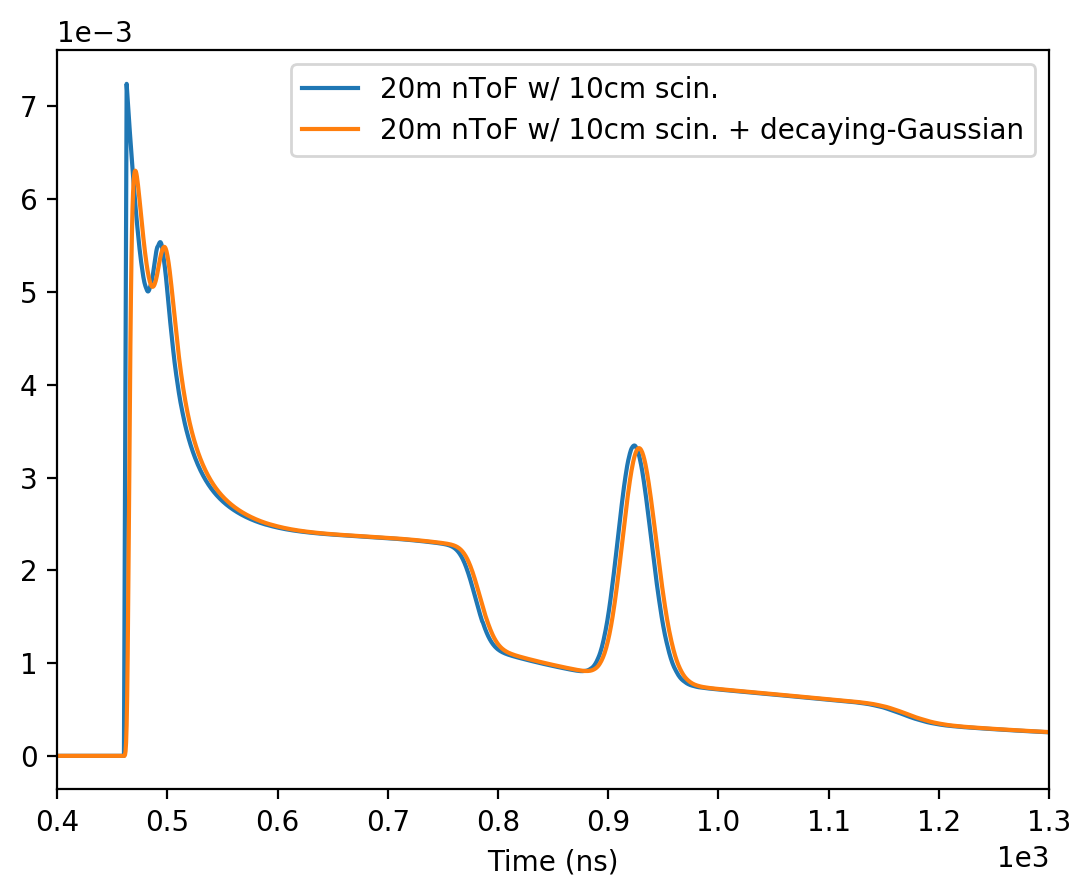

In [63]:
E_ntof = np.linspace(1.0e6,10.0e6,500)
dNdE = DT_spec_fit.model(E_ntof,rhoL,P1,vbar,dv,fT,fD,Yn)

plt.figure(dpi=200)

test_20m_nToF_1 = nst.time_of_flight.nToF(nToF_distance,flat_sens,tophat_10cmthickscintillator)
t_det,normt_det,signal = test_20m_nToF_1.get_signal(E_ntof,dNdE)
plt.plot(t_det/1e-9,signal,label='20m nToF w/ 10cm scin.')

test_20m_nToF_2 = nst.time_of_flight.nToF(nToF_distance,flat_sens,decayingGaussian_10cmthickscintillator)
t_det,normt_det,signal = test_20m_nToF_2.get_signal(E_ntof,dNdE)
plt.plot(t_det/1e-9,signal,label='20m nToF w/ 10cm scin. + decaying-Gaussian')

plt.xlim(400,1300)
plt.xlabel("Time (ns)")
plt.legend()

We can also visualise the IRF for each test synthetic nToF. The IRF is stored in normalised time space and is a matrix, encoding both the energy dependence of arrival time and temporal blurring from the diagnostic.

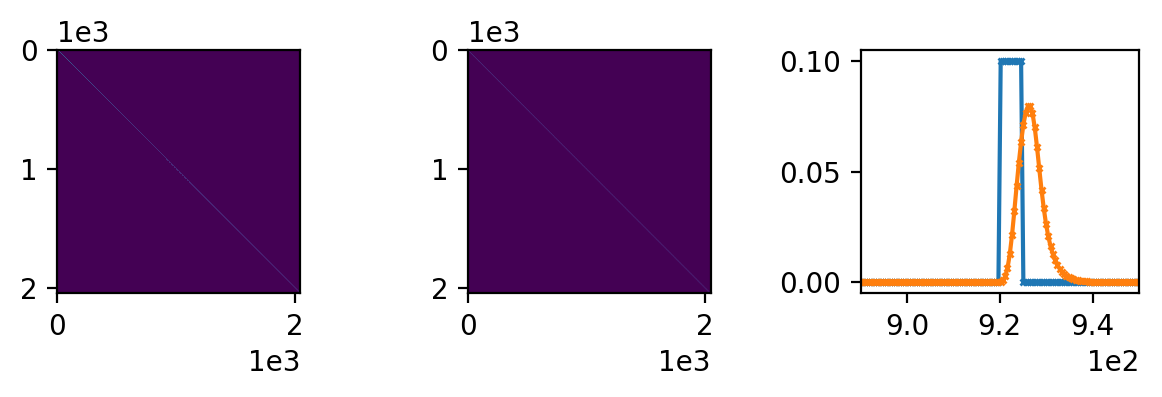

In [53]:
fig = plt.figure(dpi=200,figsize=(6,2))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(test_20m_nToF_1.R)
ax2.imshow(test_20m_nToF_2.R)
ax3.plot(t_det/1e-9,test_20m_nToF_1.R[:,1200],marker='x',markersize=2)
ax3.plot(t_det/1e-9,test_20m_nToF_2.R[:,1200],marker='x',markersize=2)
ax3.set_xlim(890,950)
fig.tight_layout()

Sensitivity functions:

Organic scintillators are commonly used for fast neutron detection. The light output function, L(E), of the scintillator can be used to calculate the neutron sensitivity. If we assume knocked on protons dominate the scintillation, the sensitivity is given by:

$$
S(E_n) \propto \frac{\sigma_H(E_n)}{E_n} \int_0^{E_n} L(E) dE
$$

Organic scintillators typically have a light output $L(E) \propto E^{3/2}$. Alternatively we can use tabulated data like that in [Verbinski et al.](https://www.sciencedirect.com/science/article/pii/0029554X68900037). 

Text(0,0.5,'Scintillator Sensitivity (A.U.)')

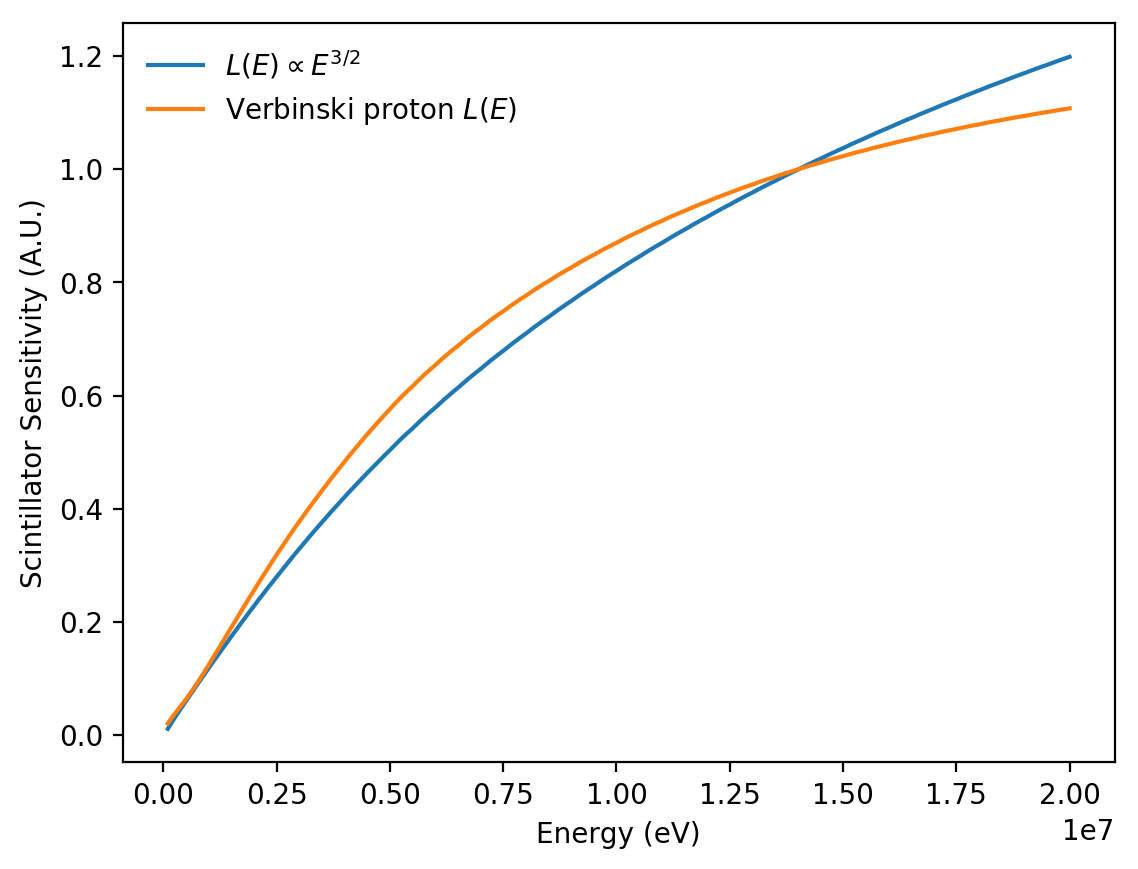

In [64]:
NLO_pwrlaw_sensitivity    = nst.time_of_flight.get_power_law_NLO(1.5)
NLO_Verbinski_sensitivity = nst.time_of_flight.get_Verbinski_NLO()

plt.figure(dpi=200)
E_ntof = np.linspace(0.1e6,20e6,200)
plt.plot(E_ntof,NLO_pwrlaw_sensitivity(E_ntof),label=r'$L(E) \propto E^{3/2}$')
plt.plot(E_ntof,NLO_Verbinski_sensitivity(E_ntof),label=r'Verbinski proton $L(E)$')

plt.legend(frameon=False)
plt.xlabel("Energy (eV)")
plt.ylabel("Scintillator Sensitivity (A.U.)")

We can also demonstrate a forward in time of flight space using NeSST's functionality. Here we consider the case of fitting a DT peak which if affected by fluid velocity effects (giving a Doppler shift and broadening).

First, we produce some synthetic data in the nToF space:

409.3985038508323 413.10963500993256


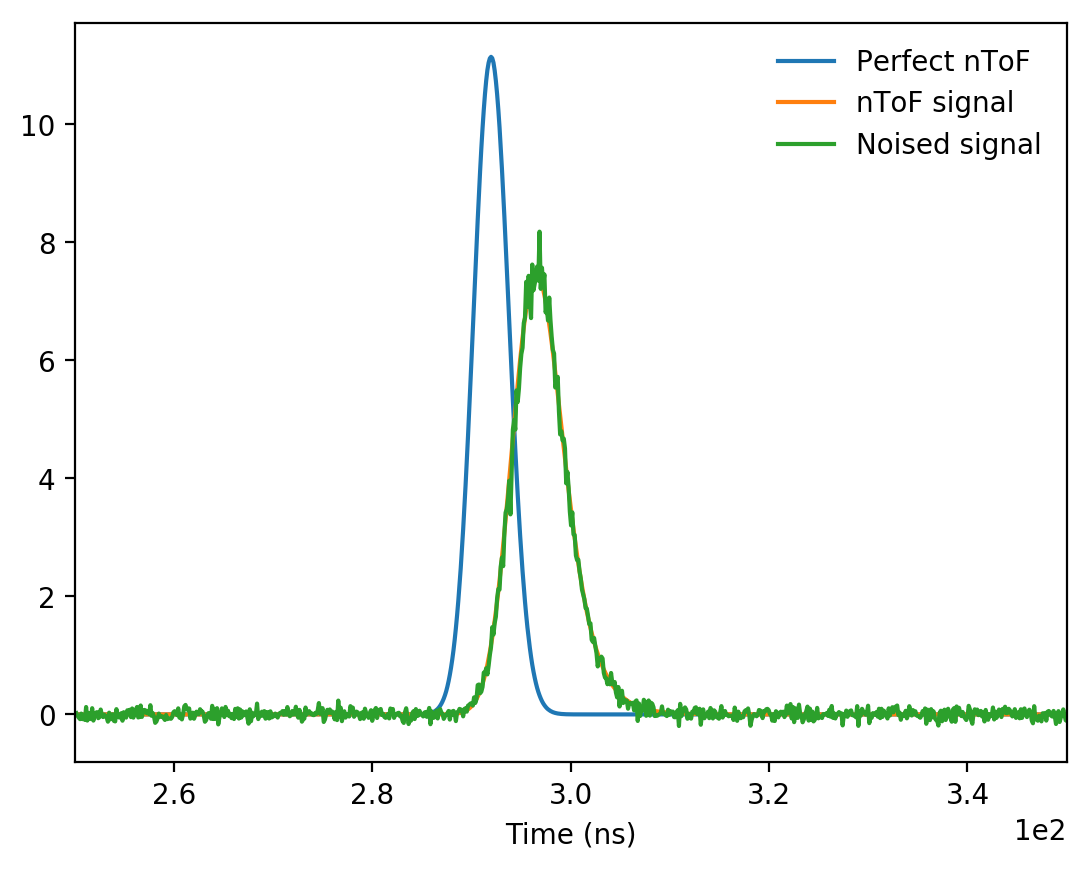

In [59]:
# Produce synthetic data
# Burn-avg temperature and thermal spectrum
Tion = 5.0e3 # eV
DTmean,_,_ = nst.DTprimspecmoments(Tion)
# Fluid velocity mean shift
vhs = 100.0e3 # m/s
DTmean = nst.neutron_velocity_addition(DTmean,vhs)
dEmean = DTmean - nst.E0_DT
# Apparent temperature
Tapp = 5.5e3 # eV
_,_,DTvar = nst.DTprimspecmoments(Tapp)

E_DTspec = np.linspace(12.5e6,15.5e6,200)

dNdE_DT = nst.QBrysk(E_DTspec,DTmean,DTvar) 

plt.figure(dpi=200)

synthetic_15m_nToF = nst.time_of_flight.nToF(15.0,NLO_Verbinski_sensitivity,decayingGaussian_10cmthickscintillator,normtime_end=10.0)
t_det,normt_det,signal = synthetic_15m_nToF.get_signal(E_DTspec,dNdE_DT)
_,_,perfect_signal = synthetic_15m_nToF.get_signal_no_IRF(E_DTspec,dNdE_DT)
relative_ntof_err = 0.05
absolute_ntof_err = 0.01*np.amax(signal)
noised_signal = signal*np.random.normal(loc=1.0,scale=relative_ntof_err,size=signal.shape[0])+np.random.normal(scale=absolute_ntof_err,size=signal.shape[0])
plt.plot(t_det/1e-9,perfect_signal,label='Perfect nToF')
plt.plot(t_det/1e-9,signal,label='nToF signal')
plt.plot(t_det/1e-9,noised_signal,label='Noised signal')

plt.xlim(250,350)
plt.xlabel("Time (ns)")
plt.legend(frameon=False)

We define standard fitting function and least squares routines (we are using the convenience of our fitting model and data being calculated on the same time points, some interpolation would be required for real data or other approaches):

In [56]:
# Define fitting function
def DT_peak_fit(t,amp,mean_shift,Tapp,synthetic_nToF,E_arr,E0=nst.E0_DT,apply_IRF=True):
    mean = E0+mean_shift

    _,_,variance = nst.DTprimspecmoments(Tapp)

    dNdE_DT = amp*nst.QBrysk(E_arr,mean,variance) 

    if(apply_IRF):
        _,_,signal = synthetic_nToF.get_signal(E_DTspec,dNdE_DT)
    else:
        _,_,signal = synthetic_nToF.get_signal_no_IRF(E_DTspec,dNdE_DT)

    return signal

# Define fitting routines and likelihood
def fit_maximum_a_posterior(t,signal,modelfunc,fit_range_func,initial,params,absolute_err,relative_err,bounds):
    idx_cut = fit_range_func(t)
    
    signal_err = relative_err*signal+absolute_err
    soln = minimize(neg_log_likelihood, initial, args=(modelfunc, params, idx_cut, t, signal, signal_err), bounds = bounds,
                    method='TNC')

    return soln

def neg_log_likelihood(theta, modelfunc, params, idx_cut, x, y, yerr):
    p = [*theta,*params]
    model = modelfunc(x,*p)
    # Chi^2
    return 0.5 * np.sum(((y[idx_cut] - model[idx_cut])/yerr[idx_cut])**2)

def DT_ntof_fit_range(x):
    return (((x < 320.0e-9) & (x > 260.0e-9)))

In [57]:
initial = [1.0,0.0,2.0e3] # amp,mean_shift,Tapp
params  = [synthetic_15m_nToF,E_DTspec]
bounds  = [(0.0,np.inf),(-1.0e6,1.0e6),(0.5e3,40.0e3)] # amp,mean_shift,Tapp

soln_fit = fit_maximum_a_posterior(t_det,noised_signal,DT_peak_fit,DT_ntof_fit_range,initial,params,absolute_ntof_err,relative_ntof_err,bounds)

true_values = [1.0,dEmean,Tapp]
tolerances = [0.1,0.2e4,0.25e3]
for i in range(len(true_values)):
    print("True: {}, Fit: {}".format(true_values[i],soln_fit.x[i]))
    assert np.isclose(true_values[i],soln_fit.x[i],atol=tolerances[i])


True: 1.0, Fit: 0.9899438543814237
True: 76168.60748445988, Fit: 77748.4762735175
True: 5500.0, Fit: 5496.701073503375


The forward fit is then performed and compares favourably to the synthetic data.

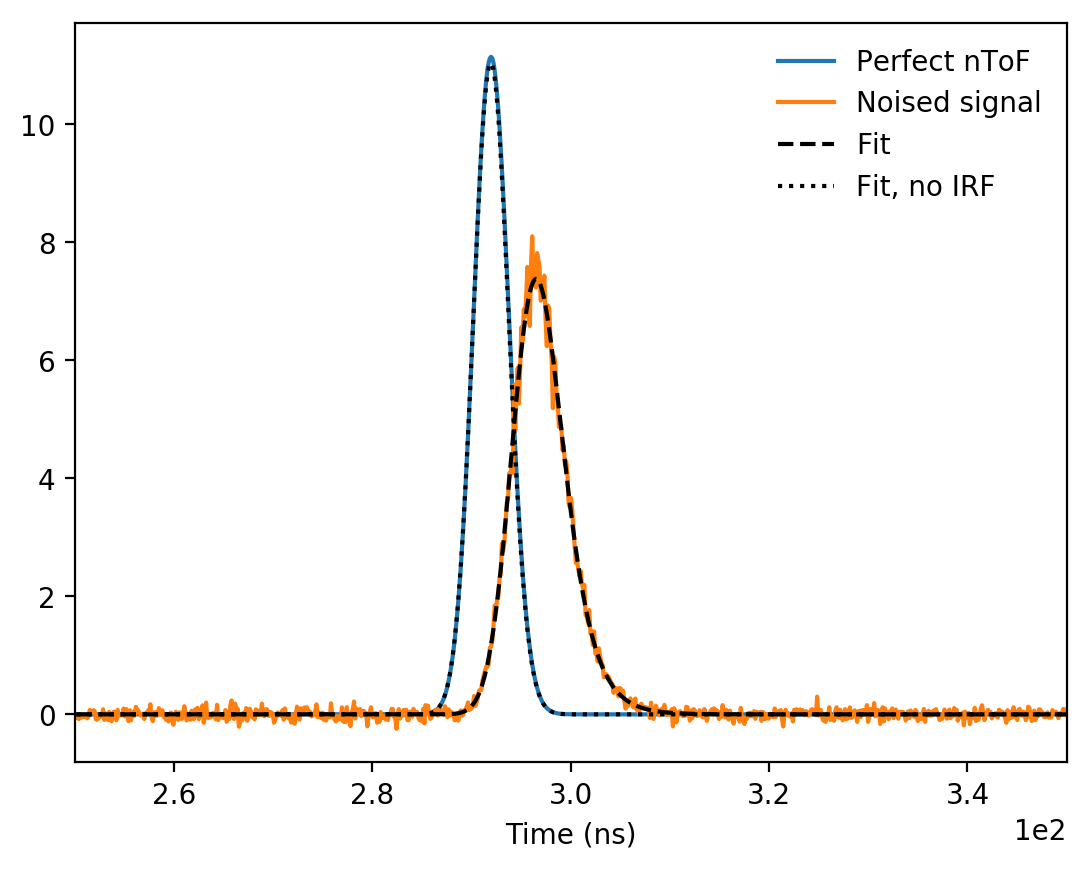

In [58]:
plt.figure(dpi=200)

plt.plot(t_det/1e-9,perfect_signal,label='Perfect nToF')
plt.plot(t_det/1e-9,noised_signal,label='Noised signal')

plt.plot(t_det/1e-9,DT_peak_fit(t_det,*soln_fit.x,*params),'k--',label='Fit')
plt.plot(t_det/1e-9,DT_peak_fit(t_det,*soln_fit.x,*params,apply_IRF=False),'k:',label='Fit, no IRF')

plt.xlim(250,350)
plt.xlabel("Time (ns)")
plt.legend(frameon=False)